___
# Exercice 2
___

Perform a simulation study to investigate the effect of penalized and unpenalized procedures seen throughout the semester, on the estimation of regression coefficients. Consider the linear model:   $$Y = x^T\beta + \epsilon$$
with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and correlated predictors $x \sim \mathcal{N}(0, \Sigma)$ where $\Sigma$ is a covariance matrix with the value 1 on the diagonal and the constant value $\rho$ for all off-diagonal values. 

In this exercise we will work with two different values for $\rho$ i.e. $\rho = 0.2$ and $0.7$. The vector $\beta$ (of length p) is of the form:    $\beta = (\beta_1, \beta_2, \beta_3, \beta_4, \beta_5, 0, \cdots, 0)^T$.

You are free to choose $\beta_1, \cdots, \beta_5$ and σ such that you distinguish between a low and high SNR = $\frac{Var(f(x))}{Var(\epsilon)}$

Simulate repeatedly (M=1000 repetitions) training and test datasets of size n = 15 and 100 (low sample size vs. high sample size) exhibiting low/high correlation and low/high SNR, from the regression model where p = 10 and 150 (low vs. high-dimensional).
Report on

(i) the accuracy of prediction on the test dataset, <br>
(ii) how well the active set is recovered (average TPR, FPR and FDR),<br>
(iii) how close the estimated values $\hat{\beta}$ are to the true $\beta$ used to generate the data.


___
### Imports and Function Definitions
___

In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import statsmodels.api as sm

# Set seed

np.random.seed(0)

In [2]:
# Functions to create dataset

def create_X(M, n, p, rho):
    """
    Create a design matrix with a given correlation rho
    """
    sigma = np.ones((p, p)) * rho + np.identity(p) * (1 - rho)
    X = np.random.multivariate_normal(np.zeros(p), sigma, n*M)
    X = np.reshape(X, (M, n, p))
    return X

def create_y(X, beta, noise_var):
    """
    Create a vector of responses
    """
    M, n, p = X.shape
    y = np.zeros((M, n))
    for i in range(M):
        y[i] = X[i].dot(beta) + np.random.normal(0, noise_var, n)
    return y

In [3]:
# Define different penalized and unpenalized models to test

def lm(X, y):
    """
    Unpenalized linear regression
    """
    model = sm.OLS(y, X)
    results = model.fit()
    return results

def ridge(X, y, alpha):
    """
    Ridge regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=0)
    return results

def lasso(X, y, alpha):
    """
    Lasso regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=1)
    return results

def elastic_net(X, y, alpha, l1_ratio):
    """
    Elastic net regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=l1_ratio)
    return results

def adaptive_lasso(X, y, alpha):
    """
    Adaptive lasso regression
    """
    model = sm.OLS(y, X)
    results = model.fit_regularized(alpha=alpha, L1_wt=1, profile_scale=True)
    return results


In [4]:
def scores(X_train, y_train, X_test, y_test, results, betas):
    
    train_mse = np.mean((y_train - results.predict(X_train))**2)
    test_mse = np.mean((y_test - results.predict(X_test))**2)

    active_set = np.where(results.params != 0)[0]

    p = X_train.shape[1]
    TP = len(np.intersect1d(active_set, betas))
    FP = len(np.setdiff1d(active_set, betas))
    FN = len(np.setdiff1d(betas, active_set))
    TN = len(np.setdiff1d(np.arange(p), np.union1d(active_set, betas)))

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FDR = FP / (FP + TP) if FP + TP > 0 else 0

    betas_error = np.mean((results.params - betas)**2)

    return train_mse, test_mse, TPR, FPR, FDR, betas_error


___
### Data Generation
___

In [12]:
# We are going to generate data to use for all the experiments

p=150
n=100
M=1000
betas = np.zeros(p)
betas[0:5] = 1

## rho = 0.2
rho = 0.2
X_train_02 = create_X(M, n, p, rho)
X_test_02 = create_X(M, n, p, rho)

# Noise variance = 0.1
noise_var = 0.1
y_train_02_01 = create_y(X_train_02, betas, noise_var)
y_test_02_01 = create_y(X_test_02, betas, 0)

# Noise variance = 10
noise_var = 10
y_train_02_10 = create_y(X_train_02, betas, noise_var)
y_test_02_10 = create_y(X_test_02, betas, 0)

## rho = 0.7
rho = 0.7
X_train_07 = create_X(M, n, p, rho)
X_test_07 = create_X(M, n, p, rho)

# Noise variance = 0.1
noise_var = 0.1
y_train_07_01 = create_y(X_train_07, betas, noise_var)
y_test_07_01 = create_y(X_test_07, betas, 0)

# Noise variance = 10
noise_var = 10
y_train_07_10 = create_y(X_train_07, betas, noise_var)
y_test_07_10 = create_y(X_test_07, betas, 0)


___
### Experiments
___

### Correlation ($\rho$) Experiment

- $M=1000$
- $n = 100$
- $p = 15$
- $\sigma = 0.1$
- $\beta_{1:5}=1$

In [15]:
p = 15
betas = np.zeros(p)
betas[0:5] = 1
alpha = 0.01

# rho = 0.2
print("rho = 0.2")

X_train = X_train_02[:,:,0:p]
X_test = X_test_02[:,:,0:p]

lm_02_01 = np.zeros(6)
ridge_02_01 = np.zeros(6)
lasso_02_01 = np.zeros(6)
elastic_net_02_01 = np.zeros(6)
adaptive_lasso_02_01 = np.zeros(6)

for i in range(M):
    lm_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], lm(X_train[i], y_train_02_01[i]), betas)
    ridge_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], ridge(X_train[i], y_train_02_01[i], alpha), betas)
    lasso_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], lasso(X_train[i], y_train_02_01[i], alpha), betas)
    elastic_net_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], elastic_net(X_train[i], y_train_02_01[i], alpha, 0.5), betas)
    adaptive_lasso_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], adaptive_lasso(X_train[i], y_train_02_01[i], alpha), betas)

lm_02_01 /= M
ridge_02_01 /= M
lasso_02_01 /= M
elastic_net_02_01 /= M
adaptive_lasso_02_01 /= M

# Save results
np.savetxt("Results/lm_02_01.csv", lm_02_01, delimiter=",")
np.savetxt("Results/ridge_02_01.csv", ridge_02_01, delimiter=",")
np.savetxt("Results/lasso_02_01.csv", lasso_02_01, delimiter=",")
np.savetxt("Results/elastic_net_02_01.csv", elastic_net_02_01, delimiter=",")
np.savetxt("Results/adaptive_lasso_02_01.csv", adaptive_lasso_02_01, delimiter=",")


# rho = 0.7
print("rho = 0.7")

X_train = X_train_07[:,:,0:p]
X_test = X_test_07[:,:,0:p]

lm_07_01 = np.zeros(6)
ridge_07_01 = np.zeros(6)
lasso_07_01 = np.zeros(6)
elastic_net_07_01 = np.zeros(6)
adaptive_lasso_07_01 = np.zeros(6)

for i in range(M):
    lm_07_01 += scores(X_train[i], y_train_07_01[i], X_test[i], y_test_07_01[i], lm(X_train[i], y_train_07_01[i]), betas)
    ridge_07_01 += scores(X_train[i], y_train_07_01[i], X_test[i], y_test_07_01[i], ridge(X_train[i], y_train_07_01[i], alpha), betas)
    lasso_07_01 += scores(X_train[i], y_train_07_01[i], X_test[i], y_test_07_01[i], lasso(X_train[i], y_train_07_01[i], alpha), betas)
    elastic_net_07_01 += scores(X_train[i], y_train_07_01[i], X_test[i], y_test_07_01[i], elastic_net(X_train[i], y_train_07_01[i], alpha, 0.5), betas)
    adaptive_lasso_07_01 += scores(X_train[i], y_train_07_01[i], X_test[i], y_test_07_01[i], adaptive_lasso(X_train[i], y_train_07_01[i], alpha), betas)
    
lm_07_01 /= M
ridge_07_01 /= M
lasso_07_01 /= M
elastic_net_07_01 /= M
adaptive_lasso_07_01 /= M

# Save results
np.savetxt("Results/lm_07_01.csv", lm_07_01, delimiter=",")
np.savetxt("Results/ridge_07_01.csv", ridge_07_01, delimiter=",")
np.savetxt("Results/lasso_07_01.csv", lasso_07_01, delimiter=",")
np.savetxt("Results/elastic_net_07_01.csv", elastic_net_07_01, delimiter=",")
np.savetxt("Results/adaptive_lasso_07_01.csv", adaptive_lasso_07_01, delimiter=",")

rho = 0.2
rho = 0.7


#### Variance of Noise ($\sigma$) Experiment

- $M=1000$
- $n = 100$
- $p = 15$
- $\rho = 0.2$
- $\beta_{1:5}=1$


In [29]:
p = 15
betas = np.zeros(p)
betas[0:5] = 1

# sigma = 10
print("sigma = 10")

X_train = X_train_02[:,:,0:p]
X_test = X_test_02[:,:,0:p]

lm_02_10 = np.zeros(6)
ridge_02_10 = np.zeros(6)
lasso_02_10 = np.zeros(6)
elastic_net_02_10 = np.zeros(6)
adaptive_lasso_02_10 = np.zeros(6)

for i in range(M):
    lm_02_10 += scores(X_train[i], y_train_02_10[i], X_test[i], y_test_02_10[i], lm(X_train[i], y_train_02_10[i]), betas)
    ridge_02_10 += scores(X_train[i], y_train_02_10[i], X_test[i], y_test_02_10[i], ridge(X_train[i], y_train_02_10[i], 0.1), betas)
    lasso_02_10 += scores(X_train[i], y_train_02_10[i], X_test[i], y_test_02_10[i], lasso(X_train[i], y_train_02_10[i], 0.1), betas)
    elastic_net_02_10 += scores(X_train[i], y_train_02_10[i], X_test[i], y_test_02_10[i], elastic_net(X_train[i], y_train_02_10[i], 0.1, 0.5), betas)
    adaptive_lasso_02_10 += scores(X_train[i], y_train_02_10[i], X_test[i], y_test_02_10[i], adaptive_lasso(X_train[i], y_train_02_10[i], 0.1), betas)

lm_02_10 /= M
ridge_02_10 /= M
lasso_02_10 /= M
elastic_net_02_10 /= M
adaptive_lasso_02_10 /= M

# Save results
np.savetxt("Results/lm_02_10.csv", lm_02_10, delimiter=",")
np.savetxt("Results/ridge_02_10.csv", ridge_02_10, delimiter=",")
np.savetxt("Results/lasso_02_10.csv", lasso_02_10, delimiter=",")
np.savetxt("Results/elastic_net_02_10.csv", elastic_net_02_10, delimiter=",")
np.savetxt("Results/adaptive_lasso_02_10.csv", adaptive_lasso_02_10, delimiter=",")



sigma = 10


#### Sample Size ($n$) Experiment

- $M=1000$
- $p = 15$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$


In [ ]:
p = 15
betas = np.zeros(p)
betas[0:5] = 1

X_train = X_train_02[:,:,0:p]
X_test = X_test_02[:,:,0:p]

lm_02_01 = np.zeros(6)
ridge_02_01 = np.zeros(6)
lasso_02_01 = np.zeros(6)
elastic_net_02_01 = np.zeros(6)
adaptive_lasso_02_01 = np.zeros(6)

n_list = [15, 30, 45, 60, 75, 90, 100]

for n in n_list:
    print(n)
    for i in range(100):
        lm_02_01 += scores(X_train[i][0:n], y_train_02_01[i][0:n], X_test[i][0:n], y_test_02_01[i][0:n], lm(X_train[i][0:n], y_train_02_01[i][0:n]), betas)
        ridge_02_01 += scores(X_train[i][0:n], y_train_02_01[i][0:n], X_test[i][0:n], y_test_02_01[i][0:n], ridge(X_train[i][0:n], y_train_02_01[i][0:n], 0.1), betas)
        lasso_02_01 += scores(X_train[i][0:n], y_train_02_01[i][0:n], X_test[i][0:n], y_test_02_01[i][0:n], lasso(X_train[i][0:n], y_train_02_01[i][0:n], 0.1), betas)
        elastic_net_02_01 += scores(X_train[i][0:n], y_train_02_01[i][0:n], X_test[i][0:n], y_test_02_01[i][0:n], elastic_net(X_train[i][0:n], y_train_02_01[i][0:n], 0.1, 0.5), betas)
        adaptive_lasso_02_01 += scores(X_train[i][0:n], y_train_02_01[i][0:n], X_test[i][0:n], y_test_02_01[i][0:n], adaptive_lasso(X_train[i][0:n], y_train_02_01[i][0:n], 0.1), betas)

    lm_02_01 /= M
    ridge_02_01 /= M
    lasso_02_01 /= M
    elastic_net_02_01 /= M
    adaptive_lasso_02_01 /= M

    # Save results
    np.savetxt("Results/lm_02_01_n=" + str(n) + ".csv", lm_02_01, delimiter=",")
    np.savetxt("Results/ridge_02_01_n=" + str(n) + ".csv", ridge_02_01, delimiter=",")
    np.savetxt("Results/lasso_02_01_n=" + str(n) + ".csv", lasso_02_01, delimiter=",")
    np.savetxt("Results/elastic_net_02_01_n=" + str(n) + ".csv", elastic_net_02_01, delimiter=",")
    np.savetxt("Results/adaptive_lasso_02_01_n=" + str(n) + ".csv", adaptive_lasso_02_01, delimiter=",")



#### Dimensionality ($p$) Experiment

- $M=1000$
- $n = 100$
- $\rho = 0.2$
- $\sigma = 0.1$
- $\beta_{1:5}=1$

In [7]:
n = 100

p_list = np.linspace(5, 150, 10, dtype=int)[9:]

for p in p_list:
    print(p)
    betas = np.zeros(p)
    betas[0:5] = 1

    X_train = X_train_02[:,:,0:p]
    X_test = X_test_02[:,:,0:p]

    lm_02_01 = np.zeros(6)
    ridge_02_01 = np.zeros(6)
    lasso_02_01 = np.zeros(6)
    elastic_net_02_01 = np.zeros(6)
    adaptive_lasso_02_01 = np.zeros(6)

    for i in range(M):
        lm_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], lm(X_train[i], y_train_02_01[i]), betas)
        ridge_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], ridge(X_train[i], y_train_02_01[i], 0.1), betas)
        lasso_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], lasso(X_train[i], y_train_02_01[i], 0.1), betas)
        elastic_net_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], elastic_net(X_train[i], y_train_02_01[i], 0.1, 0.5), betas)
        adaptive_lasso_02_01 += scores(X_train[i], y_train_02_01[i], X_test[i], y_test_02_01[i], adaptive_lasso(X_train[i], y_train_02_01[i], 0.1), betas)

    lm_02_01 /= M
    ridge_02_01 /= M
    lasso_02_01 /= M
    elastic_net_02_01 /= M
    adaptive_lasso_02_01 /= M

    # Save results
    np.savetxt("Results/lm_02_01_p=" + str(p) + ".csv", lm_02_01, delimiter=",")
    np.savetxt("Results/ridge_02_01_p=" + str(p) + ".csv", ridge_02_01, delimiter=",")
    np.savetxt("Results/lasso_02_01_p=" + str(p) + ".csv", lasso_02_01, delimiter=",")
    np.savetxt("Results/elastic_net_02_01_p=" + str(p) + ".csv", elastic_net_02_01, delimiter=",")
    np.savetxt("Results/adaptive_lasso_02_01_p=" + str(p) + ".csv", adaptive_lasso_02_01, delimiter=",")


150


___
### Results
___

#### Correlation ($\rho$) Experiment Results

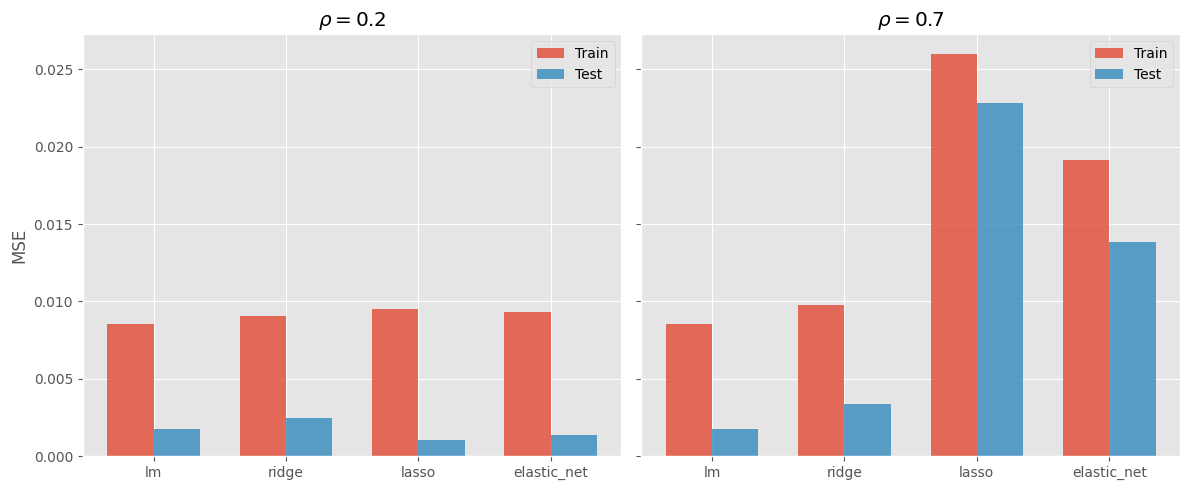

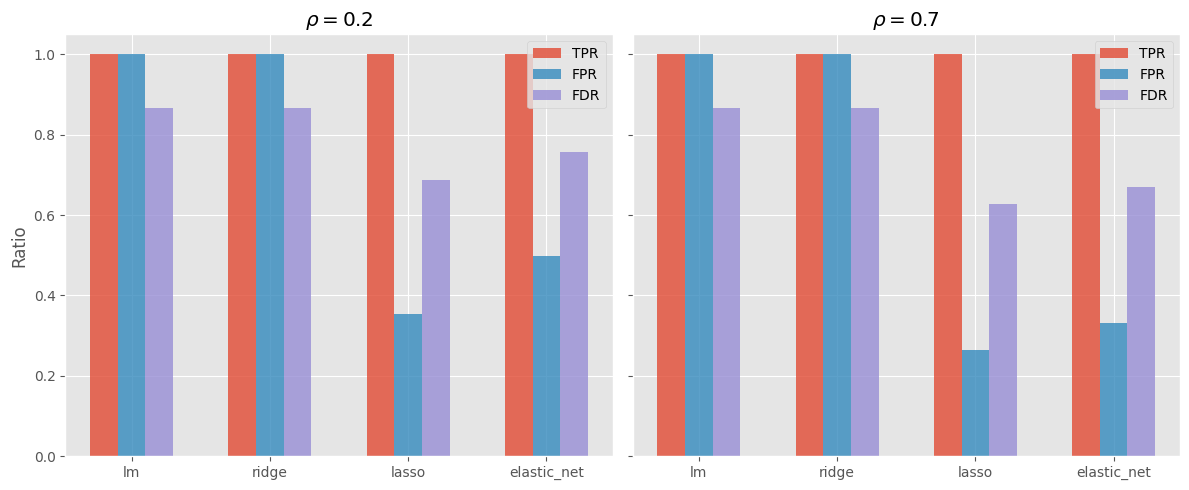

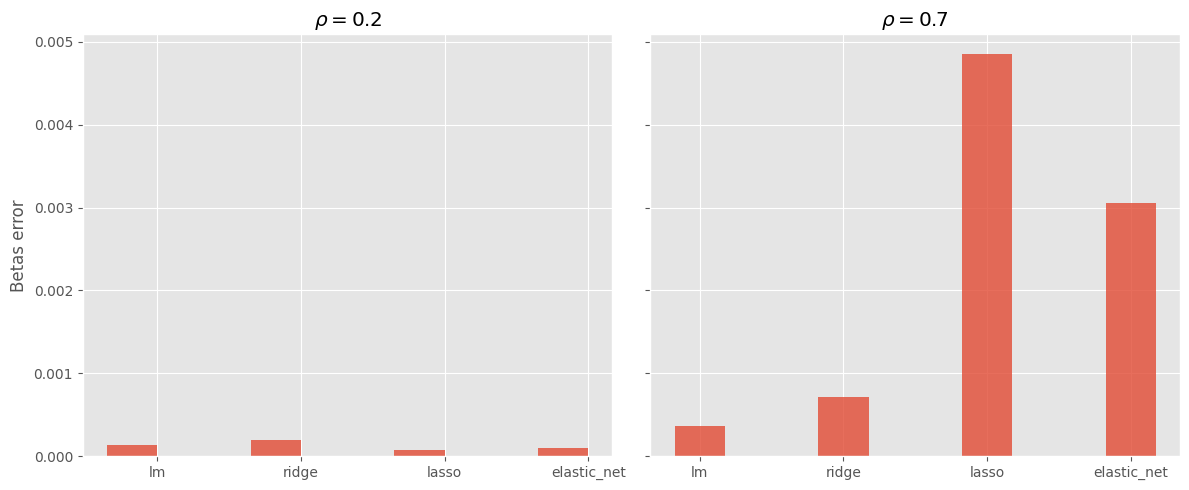

In [17]:
# Plot results for rho = 0.2 and rho = 0.7 for the 5 models tested
style.use('ggplot')

lm_02_01 = np.loadtxt("Results/lm_02_01.csv", delimiter=",")
ridge_02_01 = np.loadtxt("Results/ridge_02_01.csv", delimiter=",")
lasso_02_01 = np.loadtxt("Results/lasso_02_01.csv", delimiter=",")
elastic_net_02_01 = np.loadtxt("Results/elastic_net_02_01.csv", delimiter=",")
adaptive_lasso_02_01 = np.loadtxt("Results/adaptive_lasso_02_01.csv", delimiter=",")

lm_07_01 = np.loadtxt("Results/lm_07_01.csv", delimiter=",")
ridge_07_01 = np.loadtxt("Results/ridge_07_01.csv", delimiter=",")
lasso_07_01 = np.loadtxt("Results/lasso_07_01.csv", delimiter=",")
elastic_net_07_01 = np.loadtxt("Results/elastic_net_07_01.csv", delimiter=",")
adaptive_lasso_07_01 = np.loadtxt("Results/adaptive_lasso_07_01.csv", delimiter=",")

models = ['lm', 'ridge', 'lasso', 'elastic_net']#, 'adaptive_lasso']

# Plots MSE

mse_02 = {
    'Train': (lm_02_01[0], ridge_02_01[0], lasso_02_01[0], elastic_net_02_01[0]),# adaptive_lasso_02_01[0]),
    'Test': (lm_02_01[1], ridge_02_01[1], lasso_02_01[1], elastic_net_02_01[1]),# adaptive_lasso_02_01[1])
}

mse_07 = {
    'Train': (lm_07_01[0], ridge_07_01[0], lasso_07_01[0], elastic_net_07_01[0]),# adaptive_lasso_07_01[0]),
    'Test': (lm_07_01[1], ridge_07_01[1], lasso_07_01[1], elastic_net_07_01[1]),# adaptive_lasso_07_01[1])
}

x = np.arange(len(models))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width/2, mse_02['Train'], width, label='Train', alpha=0.8)
rects2 = ax1.bar(x + width/2, mse_02['Test'], width, label='Test', alpha=0.8)
ax1.set_ylabel('MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_title(r'$\rho = 0.2$')

rects1 = ax2.bar(x - width/2, mse_07['Train'], width, label='Train', alpha=0.8)
rects2 = ax2.bar(x + width/2, mse_07['Test'], width, label='Test', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_title(r'$\rho = 0.7$')

fig.tight_layout()
plt.savefig('Results/mse_rho.png')
plt.show()

# Plots TPR, FPR and FDR

ratios_02 = {
    'TPR': (lm_02_01[2], ridge_02_01[2], lasso_02_01[2], elastic_net_02_01[2]),# adaptive_lasso_02_01[2]),
    'FPR': (lm_02_01[3], ridge_02_01[3], lasso_02_01[3], elastic_net_02_01[3]),# adaptive_lasso_02_01[3]),
    'FDR': (lm_02_01[4], ridge_02_01[4], lasso_02_01[4], elastic_net_02_01[4]),# adaptive_lasso_02_01[4])
}

ratios_07 = {
    'TPR': (lm_07_01[2], ridge_07_01[2], lasso_07_01[2], elastic_net_07_01[2]),# adaptive_lasso_07_01[2]),
    'FPR': (lm_07_01[3], ridge_07_01[3], lasso_07_01[3], elastic_net_07_01[3]),# adaptive_lasso_07_01[3]),
    'FDR': (lm_07_01[4], ridge_07_01[4], lasso_07_01[4], elastic_net_07_01[4]),# adaptive_lasso_07_01[4])
}

x = np.arange(len(models))
width = 0.2

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width, ratios_02['TPR'], width, label='TPR', alpha=0.8)
rects2 = ax1.bar(x, ratios_02['FPR'], width, label='FPR', alpha=0.8)
rects3 = ax1.bar(x + width, ratios_02['FDR'], width, label='FDR', alpha=0.8)

ax1.set_ylabel('Ratio')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_title(r'$\rho = 0.2$')

rects1 = ax2.bar(x - width, ratios_07['TPR'], width, label='TPR', alpha=0.8)
rects2 = ax2.bar(x, ratios_07['FPR'], width, label='FPR', alpha=0.8)
rects3 = ax2.bar(x + width, ratios_07['FDR'], width, label='FDR', alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_title(r'$\rho = 0.7$')

fig.tight_layout()
plt.savefig('Results/ratios_rho.png')
plt.show()

# Plots betas error

betas_error_02 = {
    'lm': lm_02_01[5],
    'ridge': ridge_02_01[5],
    'lasso': lasso_02_01[5],
    'elastic_net': elastic_net_02_01[5],
    #'adaptive_lasso': adaptive_lasso_02_01[5]
}

betas_error_07 = {
    'lm': lm_07_01[5],
    'ridge': ridge_07_01[5],
    'lasso': lasso_07_01[5],
    'elastic_net': elastic_net_07_01[5],
    #'adaptive_lasso': adaptive_lasso_07_01[5]
}

x = np.arange(len(models))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width/2, betas_error_02.values(), width, alpha=0.8)
ax1.set_ylabel('Betas error')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title(r'$\rho = 0.2$')

rects1 = ax2.bar(x, betas_error_07.values(), width, alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_title(r'$\rho = 0.7$')

fig.tight_layout()
plt.savefig('Results/betas_error_rho.png')
plt.show()


#### Variance of Noise ($\sigma$) Experiment Results

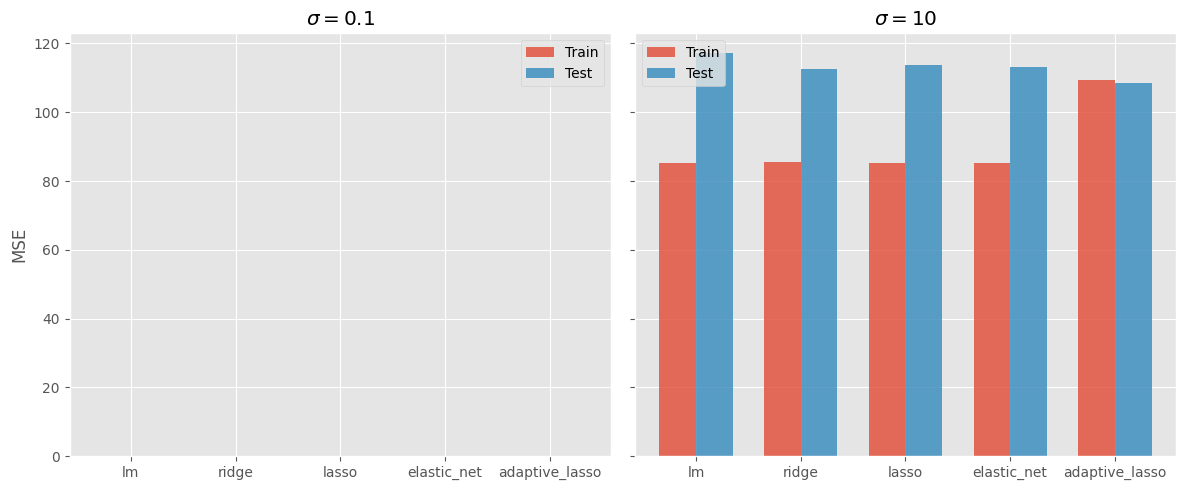

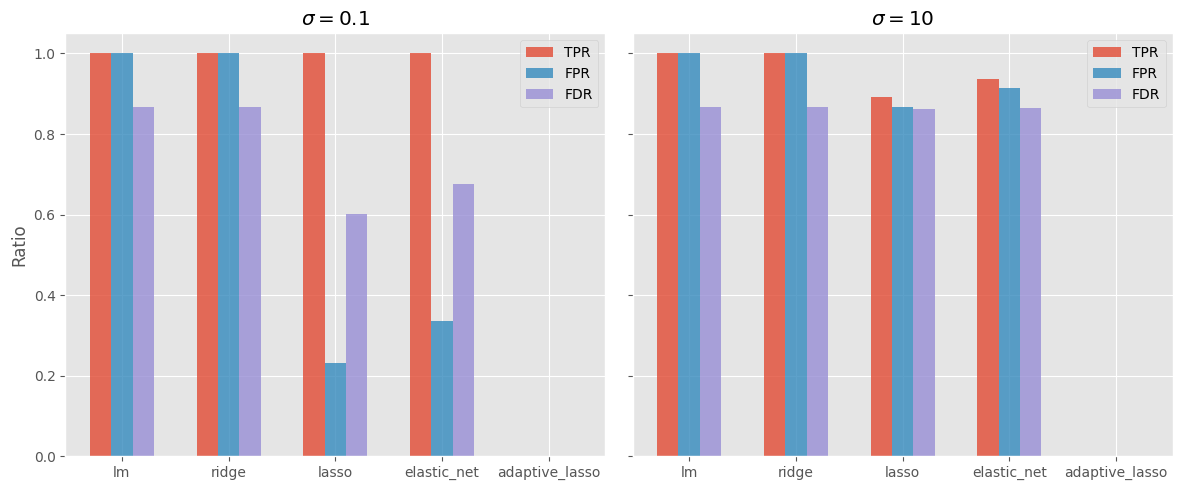

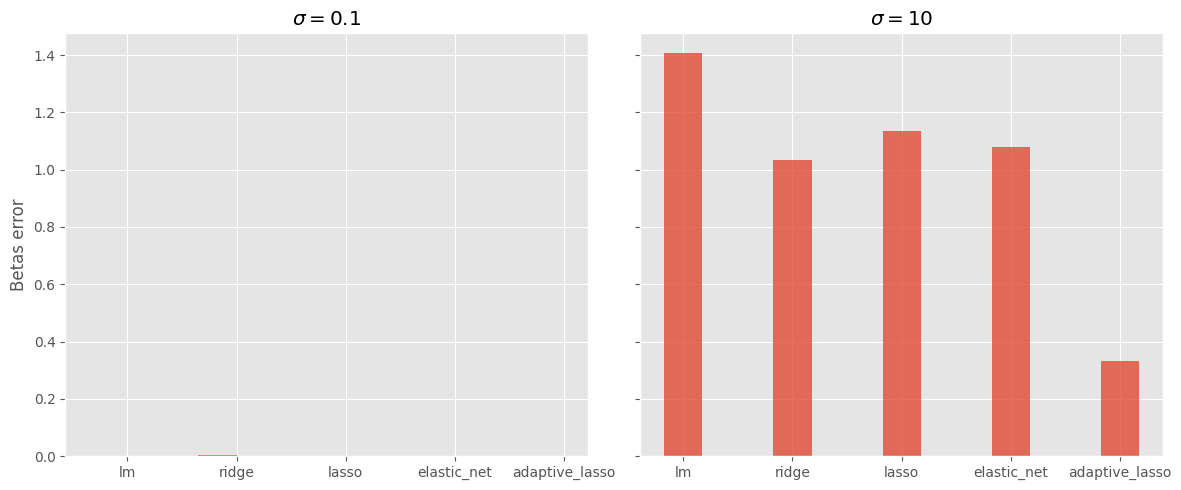

In [10]:
# Plot results for sigma = 0.1 and sigma = 10 for the 5 models tested

lm_02_01 = np.loadtxt("Results/lm_02_01.csv", delimiter=",")
ridge_02_01 = np.loadtxt("Results/ridge_02_01.csv", delimiter=",")
lasso_02_01 = np.loadtxt("Results/lasso_02_01.csv", delimiter=",")
elastic_net_02_01 = np.loadtxt("Results/elastic_net_02_01.csv", delimiter=",")
adaptive_lasso_02_01 = np.loadtxt("Results/adaptive_lasso_02_01.csv", delimiter=",")

lm_02_10 = np.loadtxt("Results/lm_02_10.csv", delimiter=",")
ridge_02_10 = np.loadtxt("Results/ridge_02_10.csv", delimiter=",")
lasso_02_10 = np.loadtxt("Results/lasso_02_10.csv", delimiter=",")
elastic_net_02_10 = np.loadtxt("Results/elastic_net_02_10.csv", delimiter=",")
adaptive_lasso_02_10 = np.loadtxt("Results/adaptive_lasso_02_10.csv", delimiter=",")

models = ['lm', 'ridge', 'lasso', 'elastic_net', 'adaptive_lasso']

# Plots MSE

mse_01 = {
    'Train': (lm_02_01[0], ridge_02_01[0], lasso_02_01[0], elastic_net_02_01[0], adaptive_lasso_02_01[0]),
    'Test': (lm_02_01[1], ridge_02_01[1], lasso_02_01[1], elastic_net_02_01[1], adaptive_lasso_02_01[1])
}

mse_10 = {
    'Train': (lm_02_10[0], ridge_02_10[0], lasso_02_10[0], elastic_net_02_10[0], adaptive_lasso_02_10[0]),
    'Test': (lm_02_10[1], ridge_02_10[1], lasso_02_10[1], elastic_net_02_10[1], adaptive_lasso_02_10[1])
}

x = np.arange(len(models))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width/2, mse_01['Train'], width, label='Train', alpha=0.8)
rects2 = ax1.bar(x + width/2, mse_01['Test'], width, label='Test', alpha=0.8)
ax1.set_ylabel('MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_title(r'$\sigma = 0.1$')

rects1 = ax2.bar(x - width/2, mse_10['Train'], width, label='Train', alpha=0.8)
rects2 = ax2.bar(x + width/2, mse_10['Test'], width, label='Test', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_title(r'$\sigma = 10$')

fig.tight_layout()
plt.savefig('Results/mse_sigma.png')
plt.show()

# Plots TPR, FPR and FDR

ratios_01 = {
    'TPR': (lm_02_01[2], ridge_02_01[2], lasso_02_01[2], elastic_net_02_01[2], adaptive_lasso_02_01[2]),
    'FPR': (lm_02_01[3], ridge_02_01[3], lasso_02_01[3], elastic_net_02_01[3], adaptive_lasso_02_01[3]),
    'FDR': (lm_02_01[4], ridge_02_01[4], lasso_02_01[4], elastic_net_02_01[4], adaptive_lasso_02_01[4])
}

ratios_10 = {
    'TPR': (lm_02_10[2], ridge_02_10[2], lasso_02_10[2], elastic_net_02_10[2], adaptive_lasso_02_10[2]),
    'FPR': (lm_02_10[3], ridge_02_10[3], lasso_02_10[3], elastic_net_02_10[3], adaptive_lasso_02_10[3]),
    'FDR': (lm_02_10[4], ridge_02_10[4], lasso_02_10[4], elastic_net_02_10[4], adaptive_lasso_02_10[4])
}

x = np.arange(len(models))
width = 0.2

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width, ratios_01['TPR'], width, label='TPR', alpha=0.8)
rects2 = ax1.bar(x, ratios_01['FPR'], width, label='FPR', alpha=0.8)
rects3 = ax1.bar(x + width, ratios_01['FDR'], width, label='FDR', alpha=0.8)

ax1.set_ylabel('Ratio')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_title(r'$\sigma = 0.1$')

rects1 = ax2.bar(x - width, ratios_10['TPR'], width, label='TPR', alpha=0.8)
rects2 = ax2.bar(x, ratios_10['FPR'], width, label='FPR', alpha=0.8)
rects3 = ax2.bar(x + width, ratios_10['FDR'], width, label='FDR', alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_title(r'$\sigma = 10$')

fig.tight_layout()
plt.savefig('Results/ratios_sigma.png')
plt.show()

# Plots betas error

betas_error_01 = {
    'lm': lm_02_01[5],
    'ridge': ridge_02_01[5],
    'lasso': lasso_02_01[5],
    'elastic_net': elastic_net_02_01[5],
    'adaptive_lasso': adaptive_lasso_02_01[5]
}

betas_error_10 = {
    'lm': lm_02_10[5],
    'ridge': ridge_02_10[5],
    'lasso': lasso_02_10[5],
    'elastic_net': elastic_net_02_10[5],
    'adaptive_lasso': adaptive_lasso_02_10[5]
}

x = np.arange(len(models))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
rects1 = ax1.bar(x - width/2, betas_error_01.values(), width, alpha=0.8)
ax1.set_ylabel('Betas error')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title(r'$\sigma = 0.1$')

rects1 = ax2.bar(x, betas_error_10.values(), width, alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_title(r'$\sigma = 10$')

fig.tight_layout()
plt.savefig('Results/betas_error_sigma.png')
plt.show()


#### Sample Size ($n$) Experiment Results

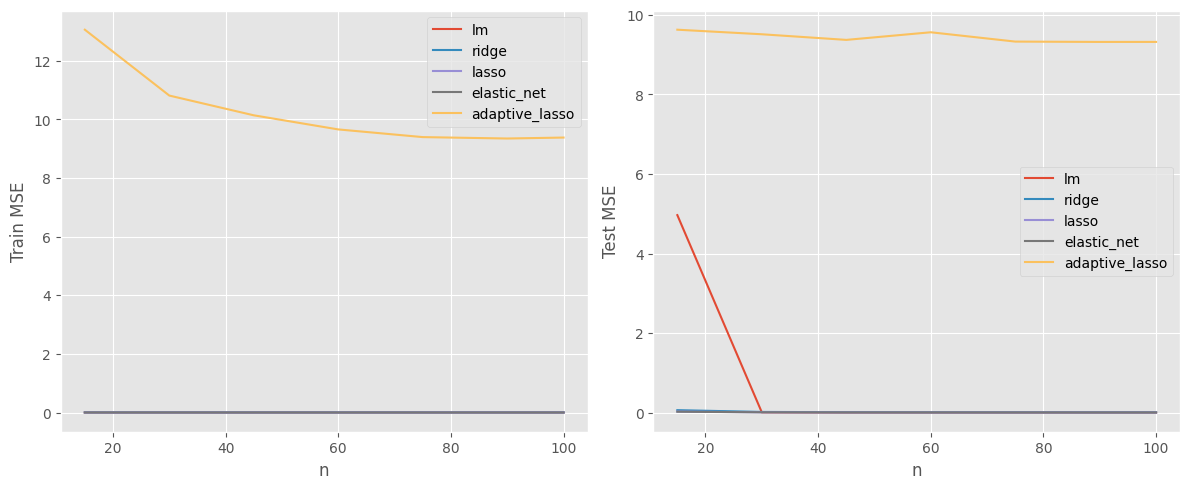

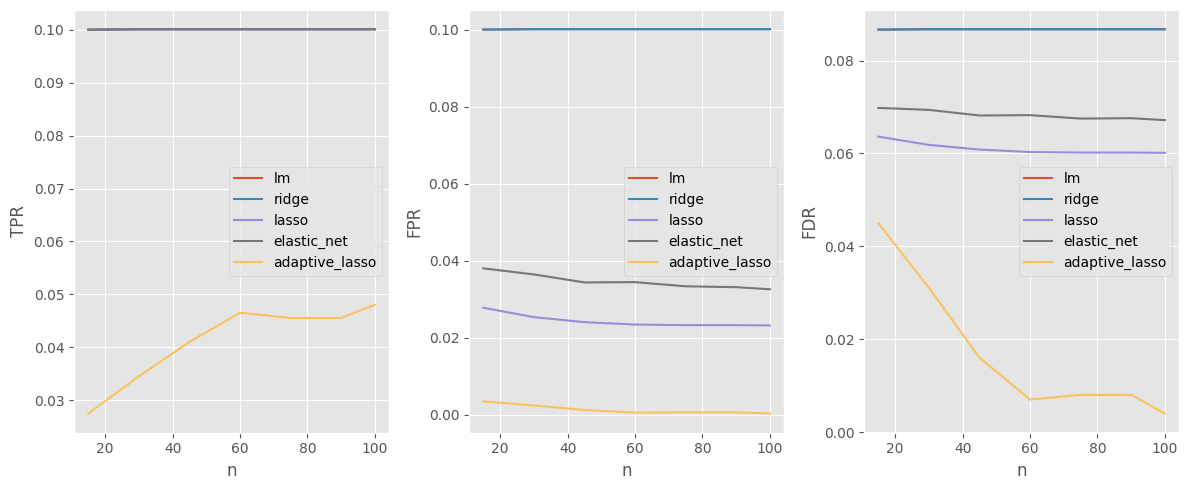

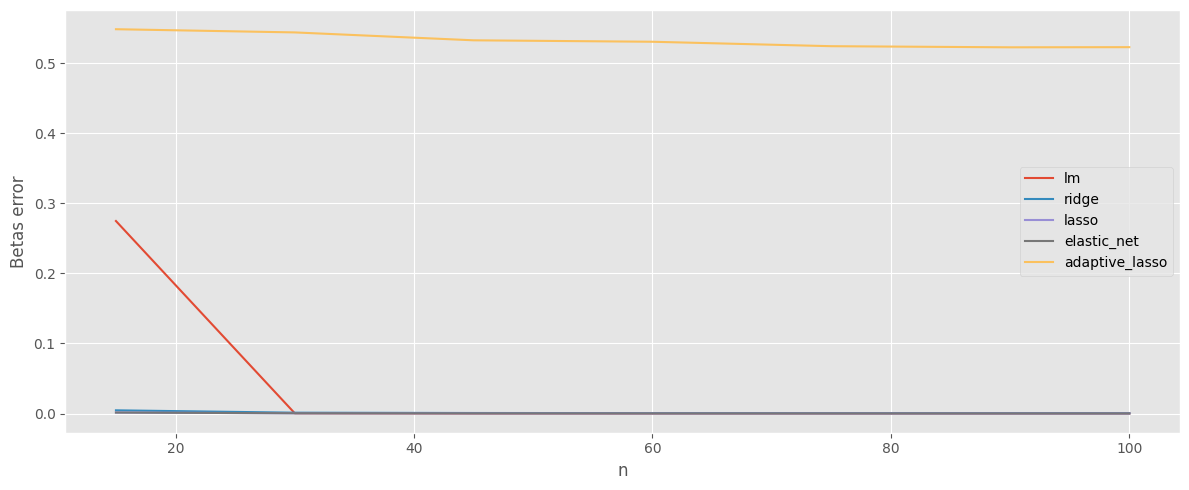

In [12]:
# Plot results for n = 15, 30, 45, 60, 75, 90, 100 for the 5 models tested

n_list = [15, 30, 45, 60, 75, 90, 100]

lm_n = []
ridge_n = []
lasso_n = []
elastic_net_n = []
adaptive_lasso_n = []

for n in n_list:
    lm_n.append(np.loadtxt("Results/lm_02_01_n=" + str(n) + ".csv", delimiter=","))
    ridge_n.append(np.loadtxt("Results/ridge_02_01_n=" + str(n) + ".csv", delimiter=","))
    lasso_n.append(np.loadtxt("Results/lasso_02_01_n=" + str(n) + ".csv", delimiter=","))
    elastic_net_n.append(np.loadtxt("Results/elastic_net_02_01_n=" + str(n) + ".csv", delimiter=","))
    adaptive_lasso_n.append(np.loadtxt("Results/adaptive_lasso_02_01_n=" + str(n) + ".csv", delimiter=","))

models = ['lm', 'ridge', 'lasso', 'elastic_net', 'adaptive_lasso']

# Plots MSE

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n_list, [lm_n[i][0] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][0] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][0] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][0] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][0] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('Train MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(n_list, [lm_n[i][1] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][1] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][1] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][1] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][1] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('Test MSE')
plt.legend()

plt.tight_layout()
plt.savefig('Results/mse_n.png')
plt.show()

# Plots TPR, FPR and FDR

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(n_list, [lm_n[i][2] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][2] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][2] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][2] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][2] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('TPR')
plt.legend()

plt.subplot(1,3,2)
plt.plot(n_list, [lm_n[i][3] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][3] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][3] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][3] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][3] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('FPR')
plt.legend()

plt.subplot(1,3,3)
plt.plot(n_list, [lm_n[i][4] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][4] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][4] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][4] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][4] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('FDR')
plt.legend()

plt.tight_layout()
plt.savefig('Results/ratios_n.png')
plt.show()

# Plots betas error

plt.figure(figsize=(12,5))
plt.plot(n_list, [lm_n[i][5] for i in range(len(n_list))], label='lm')
plt.plot(n_list, [ridge_n[i][5] for i in range(len(n_list))], label='ridge')
plt.plot(n_list, [lasso_n[i][5] for i in range(len(n_list))], label='lasso')
plt.plot(n_list, [elastic_net_n[i][5] for i in range(len(n_list))], label='elastic_net')
plt.plot(n_list, [adaptive_lasso_n[i][5] for i in range(len(n_list))], label='adaptive_lasso')
plt.xlabel('n')
plt.ylabel('Betas error')
plt.legend()

plt.tight_layout()
plt.savefig('Results/betas_error_n.png')
plt.show()


#### Dimensionality ($p$) Experiment Results

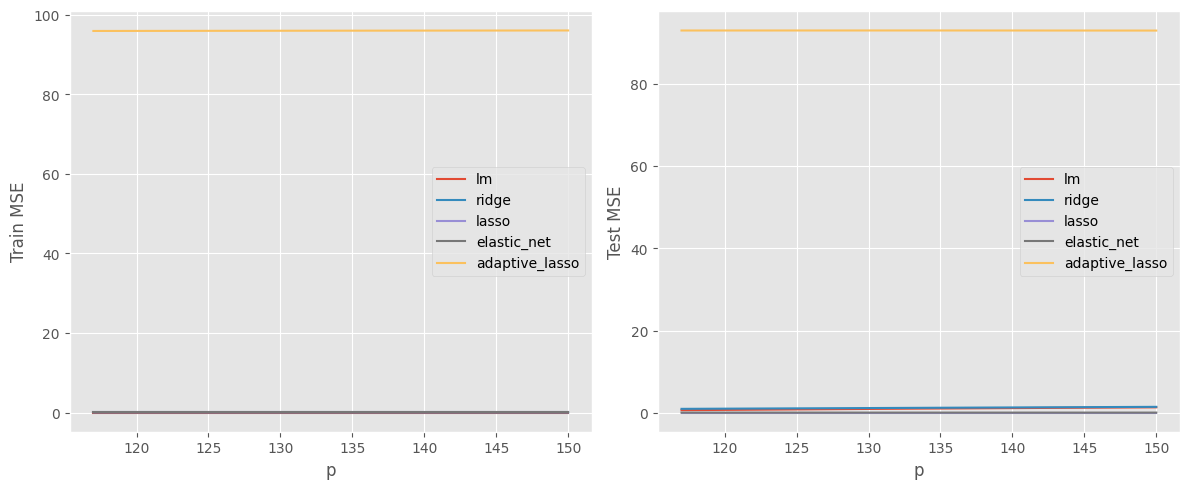

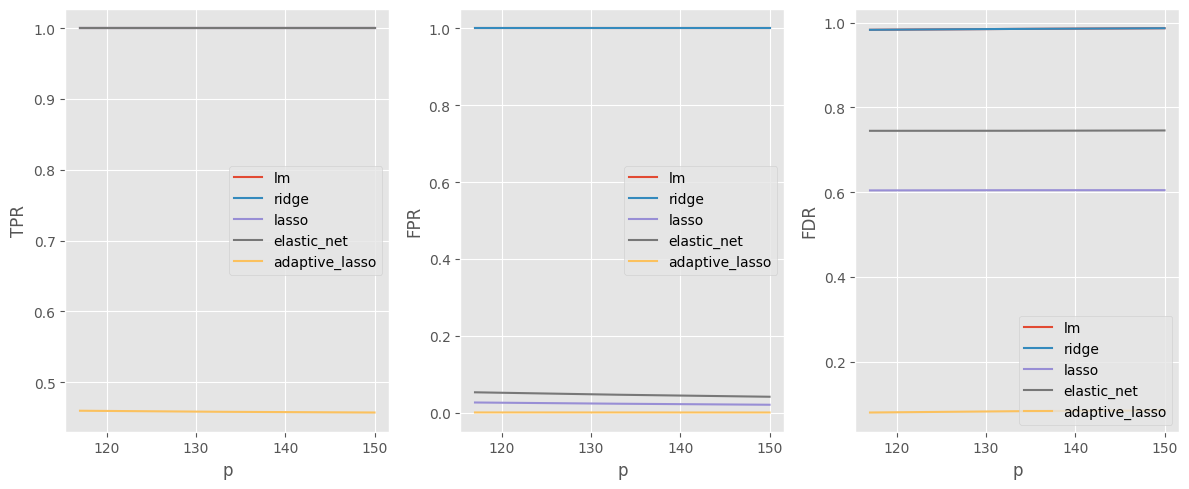

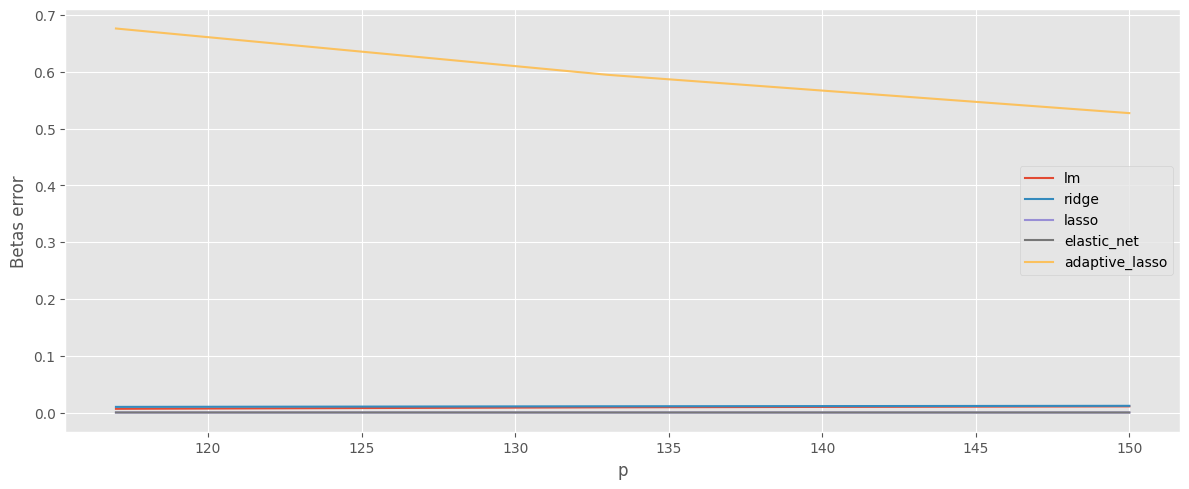

In [16]:
# Plot results for p = 5, 20, 35, 50, 65, 80, 95, 110, 125, 140, 150 for the 5 models tested

p_list = np.linspace(5, 150, 10, dtype=int)[7:]

lm_p = []
ridge_p = []
lasso_p = []
elastic_net_p = []
adaptive_lasso_p = []

for p in p_list:
    lm_p.append(np.loadtxt("Results/lm_02_01_p=" + str(p) + ".csv", delimiter=","))
    ridge_p.append(np.loadtxt("Results/ridge_02_01_p=" + str(p) + ".csv", delimiter=","))
    lasso_p.append(np.loadtxt("Results/lasso_02_01_p=" + str(p) + ".csv", delimiter=","))
    elastic_net_p.append(np.loadtxt("Results/elastic_net_02_01_p=" + str(p) + ".csv", delimiter=","))
    adaptive_lasso_p.append(np.loadtxt("Results/adaptive_lasso_02_01_p=" + str(p) + ".csv", delimiter=","))

models = ['lm', 'ridge', 'lasso', 'elastic_net', 'adaptive_lasso']

# Plots MSE

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(p_list, [lm_p[i][0] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][0] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][0] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][0] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][0] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('Train MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(p_list, [lm_p[i][1] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][1] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][1] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][1] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][1] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('Test MSE')
plt.legend()

plt.tight_layout()
plt.savefig('Results/mse_n.png')
plt.show()

# Plots TPR, FPR and FDR

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(p_list, [lm_p[i][2] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][2] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][2] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][2] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][2] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('TPR')
plt.legend()

plt.subplot(1,3,2)
plt.plot(p_list, [lm_p[i][3] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][3] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][3] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][3] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][3] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('FPR')
plt.legend()

plt.subplot(1,3,3)
plt.plot(p_list, [lm_p[i][4] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][4] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][4] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][4] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][4] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('FDR')
plt.legend()

plt.tight_layout()
plt.savefig('Results/ratios_n.png')
plt.show()

# Plots betas error

plt.figure(figsize=(12,5))
plt.plot(p_list, [lm_p[i][5] for i in range(len(p_list))], label='lm')
plt.plot(p_list, [ridge_p[i][5] for i in range(len(p_list))], label='ridge')
plt.plot(p_list, [lasso_p[i][5] for i in range(len(p_list))], label='lasso')
plt.plot(p_list, [elastic_net_p[i][5] for i in range(len(p_list))], label='elastic_net')
plt.plot(p_list, [adaptive_lasso_p[i][5] for i in range(len(p_list))], label='adaptive_lasso')
plt.xlabel('p')
plt.ylabel('Betas error')
plt.legend()

plt.tight_layout()
plt.savefig('Results/betas_error_p.png')
plt.show()